# Circuit implementation of superdense coding using TheQ

This notebook will teach you how to construct your own circuits for a superdense coding using TheQ.

# Importing packages

In [ ]:
# Server addresses should be stable, but may occasionally be offline
import requests
import json
import math
from google.colab import files
req_str = 'http://8b851bd5c0ec.ngrok.io/qsim/perform_operation'
req_str_qasm = 'http://8b851bd5c0ec.ngrok.io/qsim/qasm'

# Required functions

In [ ]:
# Define Create ciruit (these are the four core definitions for any circuit)
# all circuits must be bookmarked by the create_circuit and destroy_circuit command

# Initial_state is a binary integer to initalise all qubit, 
# most often initial_state=0.
def create_circuit(qubits,initial_state):
    data = {
        'operation': 'create_circuit',
        'num_qubits': qubits
    }
    result = requests.post(req_str, json=data)
    json_obj = json.loads(result.content)
    reg_id = json_obj['result']

    data = {
        'operation': 'set_state',
        'register': reg_id,
        'state': initial_state,
        'complex_value': {'re': 1, 'im': 0}
    }
    result = requests.post(req_str, json=data)
    return reg_id

# Gates.  gate_name and params are specified from the list above
def gate(register_id, gate_name, params):
    data = {
        'operation': 'gate',
        'register': register_id,
        'gate': gate_name
    }
    for k in params.keys():
        data[k] = params[k]
    result = requests.post(req_str, json=data)
    json_obj=json.loads(result.content)
    return json_obj['result']

# params contain an array of qubit numbers to measure, 'lq2m': [0,1,3] would measure qubits 0, 1 and 3 and return the 
# corresponding 3-bit integer value from 0 to 7.
def measure_qubit(register_id, params):
    data = {
        'operation': 'measure', 
        'register': register_id,
    }
    for k in params.keys():
        data[k] = params[k]
    result = requests.post(req_str, json=data)

    json_obj = json.loads(result.content)
    return json_obj['result']

# Always call destroy_circuit to terminate simulation (turn off your QC)
def destroy_circuit(register_id):
  data = {
        'operation': 'destroy_circuit', 
        'register': register_id
  }
  result = requests.post(req_str, json=data)

# Print allows you to output the current computational state of the machine.
def print_vector(register_id):
  data = {
        'operation': 'state_vector', 
        'register': register_id
  }
  result = requests.post(req_str, json=data)
  json_obj = json.loads(result.content)
  return json_obj['result']


# The circuits

Now, we move on to main part of the notebook. In this section, we shall explain the construction of the circuit for implementing a superdense coding protocol. The procedure enables Alice to send two bits of information to Bob. The protocol is as follows:

1. Let $q_1 q_2$ be the two bits that Alice wants to send to Bob.

2. Alice and Bob has to be sharing a Bell state $|\beta\rangle = \frac{1}{\sqrt{2}}\Big( |00\rangle + |11\rangle\Big)$ among them, that is, one qubit $q_A$ in this state should be with Alice, and the other qubit $q_B$ should be with Bob.

3. If $q_2 = 1$, Alice applies a $X$ gate on her qubit. Then, If $q_1 = 1$, Alice applies a $Z$ gate on her qubit. Then she sends her qubit to Bob.

4. Bob applies a $CNOT$ gate controlled on $q_A$ and targetted on $q_B$.

5. Then Bob applies a Hadamard gate on $q_A$. 

6. Then Bob measures both the qubits. $q_A$ will collapse to $q_1$ and $q_B$ will collapse to $q_2$.

The final circuit will then look like

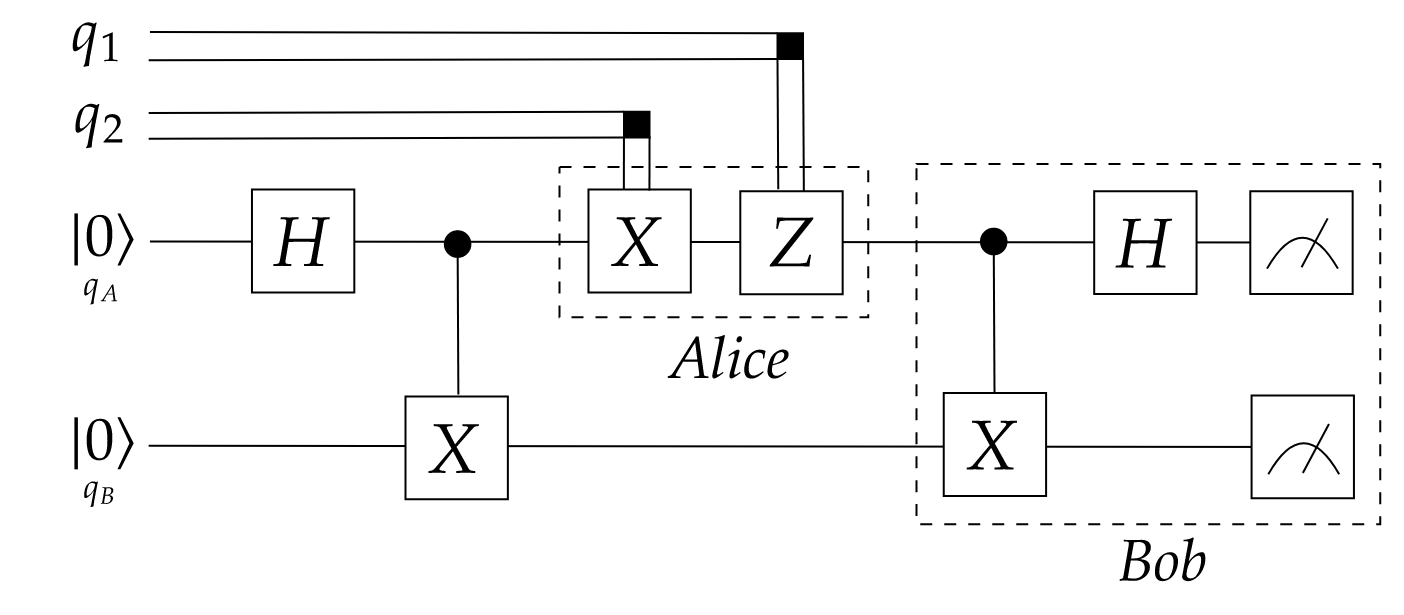

# Implementation of Superdense Coding

Now, we move on to constructing this circuit using TheQ.

## When $q_1 = 1, q_2 = 1$

Since the circuit contains two qubits, we create a circuit with two qubits.

In [ ]:
# Prepare the circuit
reg_id = create_circuit(2,0)

Now, we shall start applying the gates.

The first step is to prepare the Bell state between the qubits.


In [ ]:
# Apply Hadamard gate on qubit 0
gate(reg_id, 'hadamard', {'q': 0})

# Apply CNOT gate controlled on qubit q0 and targetted on qubit q1
gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 1})

True

Since $q_1$ and $q_2$ are both $1$, we apply an $X$ gate followed by a $Z$ gate on the first qubit.

In [ ]:
# Apply X gate on qubit 0
gate(reg_id, 'X', {'q': 0})

# Apply Z gate on qubit 0
gate(reg_id, 'Z', {'q': 0})

True

Now, it's Bob's turn. Bob applies a $CNOT$ gate followed by a Hadamard gate on the first qubit. 

In [ ]:
# Apply CNOT gate controlled on qubit q0 and targetted on qubit q1
gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 1})

# Apply Hadamard gate on qubit 0
gate(reg_id, 'hadamard', {'q': 0})

True

Finally, let's measure both the qubits.

In [ ]:
# Measure qubits 0,1
c0 = measure_qubit(reg_id,{'lq2m': [0]})
c1 = measure_qubit(reg_id,{'lq2m': [1]})

# Display measurement results
print("Q Computer returned value, first qubit = ", c0)
print("Q Computer returned value, second qubit = ", c1)

# Destroy circuit
destroy_circuit(reg_id)

Q Computer returned value, first qubit =  1
Q Computer returned value, second qubit =  1


As expected, the output is $11$. Now, let's run this circuit $20$ times and see if it always results in $11$.

In [ ]:
i = 0
results = {}

while i < 20:
    
  # Prepare the circuit
  reg_id = create_circuit(2,0)

  # Apply Hadamard gate on qubit 0
  gate(reg_id, 'hadamard', {'q': 0})

  # Apply CNOT gate controlled on qubit q0 and targetted on qubit q1
  gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 1})

  # Apply X gate on qubit 0
  gate(reg_id, 'X', {'q': 0})

  # Apply Z gate on qubit 0
  gate(reg_id, 'Z', {'q': 0})

  # Apply CNOT gate controlled on qubit q0 and targetted on qubit q1
  gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 1})

  # Apply Hadamard gate on qubit 0
  gate(reg_id, 'hadamard', {'q': 0})

  # Measure qubits 0,1
  c0 = measure_qubit(reg_id,{'lq2m': [0]})
  c1 = measure_qubit(reg_id,{'lq2m': [1]})

  try:
    results[(c0, c1)] += 1
  except KeyError:
    results[(c0, c1)] = 1

  # Destroy circuit
  destroy_circuit(reg_id)

  i = i + 1

# Display the results
print("Measurement results: {}".format(results))

Measurement results: {(1, 1): 20}


Again, as expected the result is always $11$. 

## When $q_1 = 1, q_2 = 0$

The code snippet given below runs a superdense coding protocol when $q_1 = 1, q_2 = 0$ 20 times.

In [ ]:
i = 0
results = {}

while i < 20:
    
  # Prepare the circuit
  reg_id = create_circuit(2,0)

  # Apply Hadamard gate on qubit 0
  gate(reg_id, 'hadamard', {'q': 0})

  # Apply CNOT gate controlled on qubit q0 and targetted on qubit q1
  gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 1})

  # Apply Z gate on qubit 0
  gate(reg_id, 'Z', {'q': 0})

  # Apply CNOT gate controlled on qubit q0 and targetted on qubit q1
  gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 1})

  # Apply Hadamard gate on qubit 0
  gate(reg_id, 'hadamard', {'q': 0})

  # Measure qubits 0,1
  c0 = measure_qubit(reg_id,{'lq2m': [0]})
  c1 = measure_qubit(reg_id,{'lq2m': [1]})

  try:
    results[(c0, c1)] += 1
  except KeyError:
    results[(c0, c1)] = 1

  # Destroy circuit
  destroy_circuit(reg_id)

  i = i + 1

# Display the results
print("Measurement results: {}".format(results))

Measurement results: {(1, 0): 20}


As expected the result is always $10$.  

## When $q_1 = 0, q_2 = 1$

The code snippet given below runs a superdense coding protocol when $q_1 = 0, q_2 = 1$ 20 times.

In [ ]:
i = 0
results = {}

while i < 20:
    
  # Prepare the circuit
  reg_id = create_circuit(2,0)

  # Apply Hadamard gate on qubit 0
  gate(reg_id, 'hadamard', {'q': 0})

  # Apply CNOT gate controlled on qubit q0 and targetted on qubit q1
  gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 1})

  # Apply X gate on qubit 0
  gate(reg_id, 'X', {'q': 0})

  # Apply CNOT gate controlled on qubit q0 and targetted on qubit q1
  gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 1})

  # Apply Hadamard gate on qubit 0
  gate(reg_id, 'hadamard', {'q': 0})

  # Measure qubits 0,1
  c0 = measure_qubit(reg_id,{'lq2m': [0]})
  c1 = measure_qubit(reg_id,{'lq2m': [1]})

  try:
    results[(c0, c1)] += 1
  except KeyError:
    results[(c0, c1)] = 1

  # Destroy circuit
  destroy_circuit(reg_id)

  i = i + 1

# Display the results
print("Measurement results: {}".format(results))

Measurement results: {(0, 1): 20}


As expected the result is always $01$.  

## When $q_1 = 0, q_2 = 0$

The code snippet given below runs a superdense coding protocol when $q_1 = 0, q_2 = 0$ 20 times.

In [ ]:
i = 0
results = {}

while i < 20:
    
  # Prepare the circuit
  reg_id = create_circuit(2,0)

  # Apply Hadamard gate on qubit 0
  gate(reg_id, 'hadamard', {'q': 0})

  # Apply CNOT gate controlled on qubit q0 and targetted on qubit q1
  gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 1})

  # Apply CNOT gate controlled on qubit q0 and targetted on qubit q1
  gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 1})

  # Apply Hadamard gate on qubit 0
  gate(reg_id, 'hadamard', {'q': 0})

  # Measure qubits 0,1
  c0 = measure_qubit(reg_id,{'lq2m': [0]})
  c1 = measure_qubit(reg_id,{'lq2m': [1]})

  try:
    results[(c0, c1)] += 1
  except KeyError:
    results[(c0, c1)] = 1

  # Destroy circuit
  destroy_circuit(reg_id)

  i = i + 1

# Display the results
print("Measurement results: {}".format(results))

Measurement results: {(0, 0): 20}


As expected the result is always $00$. 